Energy Disaggregation using Neural Networks
=======================================

In [1]:
import sys
import numpy as np
# sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
from scipy import signal

from sklearn.decomposition import FastICA, PCA

Using TensorFlow backend.


The following functions are used to extract the time and day information from a timestamp value.

In [2]:
def get_month(timevals):
    return dt.fromtimestamp(timevals).month
def get_week(timevals):
    return math.ceil(dt.fromtimestamp(timevals).day/7)
def get_hour(timevals):
    return dt.fromtimestamp(timevals).hour
def get_minute(timevals):
    return dt.fromtimestamp(timevals).minute
def get_second(timevals):
    return dt.fromtimestamp(timevals).second

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [3]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [4]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


Model Specification
-------------------------------
The following function is used to create the model.

In [5]:
def init_model():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu",
                    input_shape=(7,1), padding="same", strides=1))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(128, return_sequences=True,
                                  stateful=False), merge_mode='concat'))
    model.add(Bidirectional(LSTM(256, return_sequences=False, stateful=False), merge_mode='concat'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.compile(loss='mse', optimizer='adam')
    return model

The following function plots the losses against the epochs.

In [6]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [7]:
def loadData(path, index, name):
    main11 = np.genfromtxt(path+'channel_1.dat', dtype = [int, float],)
    main12 = np.genfromtxt(path1+'channel_2.dat', dtype = [int, float])
    wash1 = np.genfromtxt(path1+'channel_'+index+'.dat', dtype = [int, float])
    maindf1 = pd.DataFrame(main11)
    maindf1.columns = ["timestamp", "mains1"]
    maindf2 = pd.DataFrame(main12)
    maindf2.columns = ["timestamp", "mains2"]
    washdf1 = pd.DataFrame(wash1)
    washdf1.columns = ["timestamp", name]
    traindf1 = maindf1.merge(maindf2, on = ('timestamp'))
    traindf1 = traindf1.merge(washdf1, how="inner", on = ('timestamp'))
    timevals = traindf1["timestamp"]
    traindf1["month"] = timevals.apply(get_month)
    traindf1["week"] = timevals.apply(get_week)
    traindf1["hour"] = timevals.apply(get_hour)
    traindf1["minute"] = timevals.apply(get_minute)
    traindf1["second"] = timevals.apply(get_second)
    y = traindf1[name].values
    
    X = np.column_stack((traindf1["month"].values,traindf1["week"].values,
                     traindf1["hour"].values,traindf1["minute"].values,
                     traindf1["second"].values,traindf1["mains1"].values,
                     traindf1["mains2"].values))
   
    return X,y

ICA:
---------  
    main = main1+main2

In [10]:
path1 = ("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/low_freq/house_2/")
main11 = np.genfromtxt(path1+'channel_1.dat')
main11.shape
main11[0]

array([1.30308231e+09, 1.65700000e+01])

In [11]:
main12 = np.genfromtxt(path1+'channel_2.dat')
main12.shape

(1198534, 2)

In [12]:

mains = main11[:,1]+main12[:,1]
mains.shape
# np.reshape(mains,(mains.shape[0],1))
# mains.shape
mains=mains.reshape(len(mains),1)
mains[0]

array([306.81])

In [13]:

# main12 = np.genfromtxt(path1+'channel_2.dat', dtype = float)


# Compute ICA
ica = FastICA(n_components=2)
S_ = ica.fit_transform(mains)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
A_


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:305: UserWarning: n_components is too large: it will be set to 1
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


array([[-284210.6226166]])

In [23]:
import scipy.io
TransformWeights = scipy.io.loadmat('TransformWeights.mat')
Zica = scipy.io.loadmat('Zica.mat')
Zica['Zica']
TransformWeights['weights']

array([[ 1.57806792e-02, -1.94816305e-01,  1.83458323e-01,
         2.15430998e-01,  1.27747636e-02,  9.71093553e-02,
        -2.19649550e-01,  7.45060178e-02, -2.77656930e-01],
       [-1.88265026e-03, -2.01191963e-01,  1.90576050e-01,
         2.10737451e-01,  2.18790001e-02,  1.11144038e-01,
        -2.17341098e-01,  5.58317971e-02, -2.35229714e-01],
       [-1.05696315e-01, -1.98901285e-01,  1.90565905e-01,
         2.26270572e-01,  6.62465639e-02,  1.49884821e-01,
        -1.28658829e-01,  9.60120262e-02, -1.22226747e-01],
       [-2.14006929e-01, -1.79425023e-01,  1.27148037e-01,
         2.05365764e-01,  8.68694522e-02,  1.88090298e-01,
        -3.24339250e-02,  1.05670818e-01, -1.83932886e-02],
       [-2.65302461e-02, -1.36998764e-01,  1.26165064e-01,
         4.86261295e-02,  5.31386767e-03,  1.43489941e-01,
        -2.84228206e-01, -6.48521022e-02, -8.34522114e-02],
       [-1.52269131e-01, -1.19653081e-01,  4.85992419e-02,
         2.36367579e-02,  2.82914871e-02,  1.924775

In [ ]:
# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(mains, np.dot(S_, A_.T) + ica.mean_)

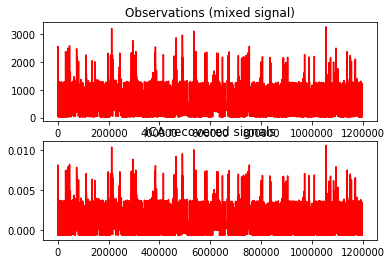

In [72]:

models = [mains, S_]
names = ['Observations (mixed signal)',
         'ICA recovered signals']
colors = ['red', 'steelblue']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(2, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

# plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

Train on 20000 samples, validate on 2000 samples
Epoch 1/20
 - 74s - loss: 0.1120 - val_loss: 0.0400
Epoch 2/20
 - 65s - loss: 0.0899 - val_loss: 0.0400
Epoch 3/20
 - 62s - loss: 0.0899 - val_loss: 0.0400
Epoch 4/20
 - 68s - loss: 0.0899 - val_loss: 0.0400
Epoch 5/20
 - 57s - loss: 0.0899 - val_loss: 0.0400
Epoch 6/20
 - 62s - loss: 0.0899 - val_loss: 0.0400
Epoch 7/20
 - 64s - loss: 0.0899 - val_loss: 0.0400
Epoch 8/20
 - 61s - loss: 0.0899 - val_loss: 0.0400
Epoch 9/20
 - 64s - loss: 0.0899 - val_loss: 0.0400
Epoch 10/20
 - 63s - loss: 0.0899 - val_loss: 0.0400
Epoch 11/20
 - 64s - loss: 0.0899 - val_loss: 0.0400
Epoch 12/20
 - 62s - loss: 0.0899 - val_loss: 0.0400
Epoch 13/20
 - 65s - loss: 0.0899 - val_loss: 0.0400
Epoch 14/20
 - 65s - loss: 0.0899 - val_loss: 0.0400
Epoch 15/20
 - 67s - loss: 0.0899 - val_loss: 0.0400
Epoch 16/20
 - 65s - loss: 0.0899 - val_loss: 0.0400
Epoch 17/20
 - 76s - loss: 0.0899 - val_loss: 0.0400
Epoch 18/20
 - 65s - loss: 0.0899 - val_loss: 0.0400
Epoch 

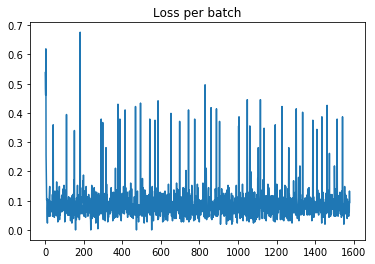

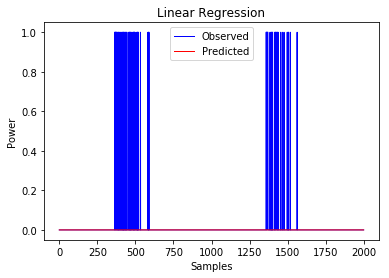

In [22]:

path1 = ("C:/Users/Purboday Ghosh/Downloads/low_freq/house_1/")
X, y = loadData(path1, "6", "dishwasher")
y = y.reshape(len(y), 1)
start = random.randrange(0, X.shape[0]-22000)
X_train = X[start:start+20000,:]
y_train = y[start:start+20000,:]
#X_train,y_train = mini_batch(X,y,10000)
X_test = X[start+20001:start+22001,:]
y_test = y[start+20001:start+22001,:]
#X_test,y_test = mini_batch(X,y,1000)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = init_model()
history = LossHistory()
model.fit(X_train, y_train, epochs=20, batch_size=256,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)
samples = range(len(y_test))
plt.plot(samples,y_test, color='blue', linewidth=1, label = 'Observed') 
plt.plot(samples,y_pred, color='red', linewidth=1, label = 'Predicted') 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Power')
plt.show()